##  <font color='black'>Important Imports</font>

In [ ]:
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
from tensorflow import optimizers
from tensorflow import keras
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras import Sequential
import os # accessing directory structure
import tensorflow as tf

from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization

import warnings
#Supress warnings
warnings.filterwarnings('ignore')

In [2]:
DATASET_PATH = r"C:\Users\Admin\Desktop\Winter 2022\CISC 351\Assignments\351A2"
print(os.listdir(DATASET_PATH))

['.idea', '.ipynb_checkpoints', 'A2.ipynb', 'A2Final.ipynb', 'A2good.ipynb', 'dsProject', 'images', 'styles.csv', 'test.csv', 'train.csv', 'venv']






##  <font color='black'>Explanatory Analysis/Original Dataset</font>

In [3]:
df = pd.read_csv(DATASET_PATH + "\styles.csv", error_bad_lines=False)
#Display first 10 rows
df.head(3)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch


##  <font color='black'>Creating access to the JPGs from the DataFrame</font>
Using a lambda function, create an extra column which contains the Path to the photo associated with the ID.

In [4]:
#Create new column containing image path
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
#ex: if id= 42069 => image = 42069.jpg






##  <font color='black'>Remove any Unnecessary columns</font>

In [5]:
#Drop columns
df = df.drop(['gender','baseColour','season','year','usage','productDisplayName','articleType','masterCategory'], axis = 1)

#Show unique Categories (Classes)
df.head()
for col in df:
    print(df[col].unique())

#Replace all attributes that are not in the 13 Subcategories with 'Other' Label
df['subCategory'] = df['subCategory'].replace(['Belts', 'Socks', 'Apparel Set', 'Ties','Lips','Free Gifts','Flip Flops','Saree','Skin','Scarves','Shoe Accessories','Headwear','Accessories','Nails','Gloves' ,'Mufflers','Skin Care','Eyes', 'Bath and Body','Cufflinks','Sports Equipment','Stoles','Hair','Umbrellas','Vouchers','Perfumes','Home Furnishing','Wristbands','Loungewear and Nightwear','Dress', 'Beauty Accessories','Water Bottle','Sports Accessories'], 'Other')

[15970 39386 59263 ... 18842 46694 51623]
['Topwear' 'Bottomwear' 'Watches' 'Socks' 'Shoes' 'Belts' 'Flip Flops'
 'Bags' 'Innerwear' 'Sandal' 'Shoe Accessories' 'Fragrance' 'Jewellery'
 'Lips' 'Saree' 'Eyewear' 'Nails' 'Scarves' 'Dress'
 'Loungewear and Nightwear' 'Wallets' 'Apparel Set' 'Headwear' 'Mufflers'
 'Skin Care' 'Makeup' 'Free Gifts' 'Ties' 'Accessories' 'Skin'
 'Beauty Accessories' 'Water Bottle' 'Eyes' 'Bath and Body' 'Gloves'
 'Sports Accessories' 'Cufflinks' 'Sports Equipment' 'Stoles' 'Hair'
 'Perfumes' 'Home Furnishing' 'Umbrellas' 'Wristbands' 'Vouchers']
['15970.jpg' '39386.jpg' '59263.jpg' ... '18842.jpg' '46694.jpg'
 '51623.jpg']


##  <font color='black'>This Block of code consists of data-preprocessing the whole dataset. It removes all rows which don't have associated JPGs.</font>


In [6]:
#Invalid IDs
invalid_ids = []

#Iterate through and try to open each photo associated with ID.
for name in df.id:
    try:
        fn=open('images/'+str(name)+'.jpg')
    except:
        # Images for certain ids are missing, so they are not added to the dataset
        invalid_ids.append(name)

#print(invalid_ids)
#print('length:')
#print(len(invalid_ids))
df = df[~df['id'].isin(invalid_ids)]
#print(df)

##  <font color='black'>Remove Rows for which Associated JPG is missing/not provided in both Test and Train, separately</font>

In [7]:
#a = Test, b = Train

#Read CSV using tab delimiter

a = pd.read_csv('test.csv', sep='\t')
b = pd.read_csv('train.csv', sep='\t')

#Apply lambda function to create new column with image Path

a['image'] = a.apply(lambda row: str(row['imageid']) + ".jpg", axis=1)
b['image'] = b.apply(lambda row: str(row['imageid']) + ".jpg", axis=1)

#Drop 'useless' column

a = a.drop(columns=['productname'])
b = b.drop(columns=['productname'])

#Rename for consistency with main DF

a.rename(columns={'label': 'subCategory','imageid':'id'}, inplace=True)
b.rename(columns={'label': 'subCategory','imageid':'id'}, inplace=True)

#Invalid IDs
invalid_idsA = []
invalid_idsB = []

#Remove invalid rows in test data
for name in a.id:
    try:
        fn=open('images/'+str(name)+'.jpg')
    except:
        invalid_idsA.append(name)
        # Images for certain ids are missing, so they are not added to the dataset
a = a[~a['id'].isin(invalid_idsA)]

#Remove invalid rows in training data
for name in b.id:
    try:
        fn=open('images/'+str(name)+'.jpg')
    except:
        invalid_idsB.append(name)
        # Images for certain ids are missing, so they are not added to the dataset
b = b[~b['id'].isin(invalid_idsB)]

#---------------------------------------------------------------------------------
#Debugging

#print(a)
#print(b)
#print(a.dtypes)
#print(b.dtypes)
#print(df.dtypes)

##  <font color='black'>Use of ImageDataGenerator to facilitate fetching and conversion of images</font>


In [8]:
#Batch size, a hyperparameter
batch_size = 32

image_generator = ImageDataGenerator(
    #20/80 validation split
    validation_split=0.2,

    #rescaling factor
    rescale=1./255
)

#Training generator
training_generator = image_generator.flow_from_dataframe(
    #Training data
    dataframe=b,
    #Image directory
    directory=DATASET_PATH + "\images",
    x_col="image",
    y_col="subCategory",
    class_mode="categorical",

    #Dimensions to which all images found will be resized(hyperparameter)
    target_size=(32,32),
    batch_size=batch_size,
    validate_filenames=False,
    subset="training"
)

validation_generator = image_generator.flow_from_dataframe(
    #Validation data
    dataframe=a,
    #Image directory
    directory=DATASET_PATH + "\images",
    x_col="image",
    y_col="subCategory",
    class_mode="categorical",

    #Dimensions to which all images found will be resized(hyperparameter)
    target_size=(32,32),
    batch_size=batch_size,
    validate_filenames=False,
    subset="validation"
)

classes = len(training_generator.class_indices)

Found 32344 non-validated image filenames belonging to 13 classes.
Found 799 non-validated image filenames belonging to 13 classes.


##  <font color='black'>Part 1: Image Classification using CNN(50 points)</font>


In [9]:

#Sequential model
model = Sequential()

#Convolutions and Activation Layers
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
#RELU = Rectified Linear Unit ( n if n >0, 0 if n<0)

#Max Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

#Dropout Layer to prevent overfitting
model.add(Dropout(0.25))

#Convolutions and Activation Layers
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

#Max Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

#Dropout Layer to prevent overfitting
model.add(Dropout(0.25))

#Flatten layer
model.add(Flatten())

#Dense Layer(each neuron receives input from all previous outputs)
model.add(Dense(512))

#Activation Layer
model.add(Activation('relu'))

#Dropout to prevent overfitting
model.add(Dropout(0.5))
model.add(Dense(13, activation='softmax'))

#Using Adam optimizer
model.compile(optimizers.Adam(lr=0.0001),loss="categorical_crossentropy", metrics=["accuracy"])

#Model Hyperparameters
STEP_SIZE_TRAIN=training_generator.n//training_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

#Set epochs, another hyperparameter ( +For later visualisation):
hist = model.fit_generator(generator=training_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=validation_generator, validation_steps=STEP_SIZE_VALID, epochs=10)




Epoch 1/10
1010/1010 [==============================] - 57s 56ms/step - loss: 1.0149 - accuracy: 0.6826 - val_loss: 0.5642 - val_accuracy: 0.8411
Epoch 2/10
1010/1010 [==============================] - 64s 64ms/step - loss: 0.5582 - accuracy: 0.8265 - val_loss: 0.4250 - val_accuracy: 0.8841
Epoch 3/10
1010/1010 [==============================] - 62s 61ms/step - loss: 0.4574 - accuracy: 0.8588 - val_loss: 0.3507 - val_accuracy: 0.9023
Epoch 4/10
1010/1010 [==============================] - 62s 61ms/step - loss: 0.3991 - accuracy: 0.8750 - val_loss: 0.3005 - val_accuracy: 0.9115
Epoch 5/10
1010/1010 [==============================] - 59s 59ms/step - loss: 0.3568 - accuracy: 0.8895 - val_loss: 0.2947 - val_accuracy: 0.9180
Epoch 6/10
1010/1010 [==============================] - 61s 60ms/step - loss: 0.3265 - accuracy: 0.8972 - val_loss: 0.2606 - val_accuracy: 0.9258
Epoch 7/10
1010/1010 [==============================] - 59s 59ms/step - loss: 0.3034 - accuracy: 0.9038 - val_loss: 0.2610 -

In [10]:
#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

##  <font color='black'>Part 2: Improved Image Classification(50 Points)</font>

For the second part of this Assignment, I chose to improve on my previous model by attempting transfer leaning. I used the pre-trained VGG-16 Model, and fixed most of the layers so they are not trained.

First, we can look at some evaluation metrics for our first model:

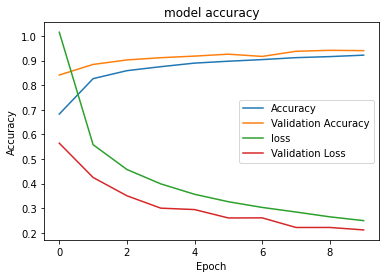

In [11]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

##  <font color='black'>Transfer Learning using VGG-16 Pre-trained Model: </font>

In [12]:
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16


 #Model Hyper-parameters
batch_size = 16
image_width, image_height = 32, 32

trdata = ImageDataGenerator(

    #rescaling factor
    rescale=1./255
)

#Train data
traindata = trdata.flow_from_dataframe(dataframe = b,
                                       directory=DATASET_PATH + "\images",
                                       x_col="image",
                                       y_col="subCategory",
                                       batch_size=batch_size,
                                       class_mode="categorical",
                                       subset="training",
                                       target_size=(image_width,image_height))

tsdata = ImageDataGenerator(rescale=1./255)

#Test Data
testdata = tsdata.flow_from_dataframe(dataframe = a,
                                      directory=DATASET_PATH + "\images",
                                      x_col="image",
                                      y_col="subCategory",
                                      batch_size=batch_size,
                                      class_mode="categorical",
                                      subset="validation",
                                      target_size=(image_width,image_height))




#Pre-trained VGG-16 Model, not including top convolution layers
pre_trained_model = VGG16(
    input_shape=(image_width,image_height,3),
    include_top=False,
    weights="imagenet" #Pre-trained weights
)

#Do not train pre-trained layers
for layer in pre_trained_model.layers:
    layer.trainable=False


#Model Definition
model = tf.keras.models.Sequential(
    [
    pre_trained_model,
    Flatten(),
    Dense(256,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(13, activation='softmax')
])

#Model Hyperparameters
STEP_SIZE_TRAIN=traindata.n//traindata.batch_size
STEP_SIZE_VALID=testdata.n//testdata.batch_size

#Print Summary
model.summary()


Found 40429 validated image filenames belonging to 13 classes.
Found 0 validated image filenames belonging to 13 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                

In [13]:

#Compile using same evaluation metric and optimizer
model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics = ['acc']
)

#Collect data for performance and visualisation
hist = model.fit_generator(
    traindata,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_steps=STEP_SIZE_VALID,
    validation_data=testdata,
    epochs=10
)


Epoch 1/10
2526/2526 [==============================] - 132s 52ms/step - loss: 0.7193 - acc: 0.7767
Epoch 2/10
2526/2526 [==============================] - 135s 53ms/step - loss: 0.5609 - acc: 0.8204
Epoch 3/10
2526/2526 [==============================] - 139s 55ms/step - loss: 0.5249 - acc: 0.8309
Epoch 4/10
2526/2526 [==============================] - 124s 49ms/step - loss: 0.5022 - acc: 0.8399
Epoch 5/10
2526/2526 [==============================] - 99s 39ms/step - loss: 0.4870 - acc: 0.8452
Epoch 6/10
2186/2526 [========================>.....] - ETA: 13s - loss: 0.4789 - acc: 0.8489


KeyboardInterrupt



In [ ]:
#Model Performance and Data visualisation
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['loss'])
plt.title("model accuracy and loss")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","loss"])
plt.show()

In [ ]:
#Test Data accuracy
from sklearn.metrics import accuracy_score
y_test=model.predict(testdata)
y_pred=np.argmax(y_pred,axis=0)
accuracy_score(ytest, y_pred)

##  <font color='black'>Conclusion</font>

The first model performed better than the Transfer Learning model.(92 vs 85.5 accuracy) One reason for this is because the transfer learning model had a lot more layers, and it would require a lot longer to train. In order to tinker with the layers, I did not have time to let the 2nd model learn properly, and for this reason it is not better. If I had more time, maybe 2nd model could be better accuracy!